# WorkFlow

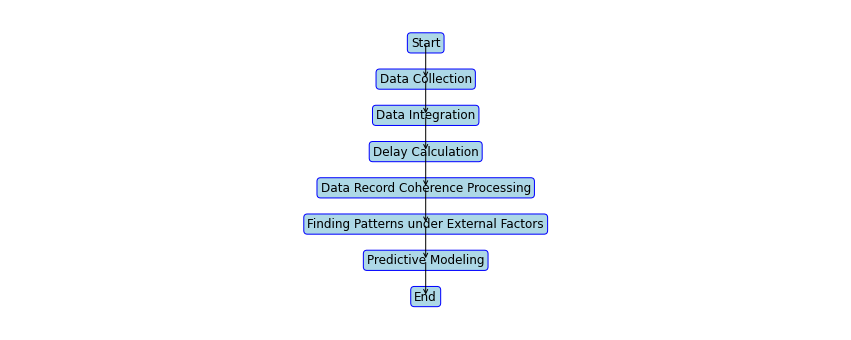

In [8]:
import matplotlib.pyplot as plt

elements = {
    'Start': (0, 0),
    'Data Collection': (0, -1),
    'Data Integration': (0, -2),
    'Delay Calculation': (0, -3),
    'Data Record Coherence Processing': (0, -4),
    'Finding Patterns under External Factors': (0, -5),
    'Predictive Modeling': (0, -6),
    'End': (0, -7)
}

connections = [
    ('Start', 'Data Collection'),
    ('Data Collection', 'Data Integration'),
    ('Data Integration', 'Delay Calculation'),
    ('Delay Calculation', 'Data Record Coherence Processing'),
    ('Data Record Coherence Processing', 'Finding Patterns under External Factors'),
    ('Finding Patterns under External Factors', 'Predictive Modeling'),
    ('Predictive Modeling', 'End')
]

fig, ax = plt.subplots(figsize=(15, 6))

for element, (x, y) in elements.items():
    ax.annotate(element, (x, y), fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', edgecolor='blue', facecolor='lightblue'))

for start, end in connections:
    x1, y1 = elements[start]
    x2, y2 = elements[end]
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(arrowstyle='->'))

ax.set_xlim(-1, 1)
ax.set_ylim(-8, 1)
ax.axis('off')

plt.show()

# 1. Data Collection
## I collect the data from 2023-07-22 to 2023-08-06 as my test datasets in Nottingham, Brighton and London. Only Nottingham's here as an example.

In [2]:
# API KEY for BODS data
api = '41fcb7776502fc84069f216601dc7721722b304d'

## 1.1 BODS SIRI-VM data(REAL-TIME Location) API: https://www.postman.com/spencerbrittain-kpmg/workspace/bods-example/request/24580877-89597ef7-a759-4d8a-91f3-e47d893446db?ctx=code

SAVED AS ./location_data/location_Nottingham_xml.csv

In [6]:
# modify the API to save SIRI-VM data as csv files every 50s

import xml.etree.ElementTree as ET
import csv
from bods_client.client import BODSClient
from bods_client.models import BoundingBox, SIRIVMParams
import os
import time
from datetime import datetime
import pandas as pd

class Siri:

    def __init__(self, xml):
        self.xml = xml
        self.dict = self.parse(self.xml)

    def parse(self, raw_xml):
        tree = ET.ElementTree(ET.fromstring(raw_xml))
        root = tree.getroot()
        return self.parse_element(root)

    def parse_element(self, element):
        data = {}

        for current in element:
            name = current.tag[29:]

            if current:
                if name in data:
                    if not isinstance(data[name], list):
                        temp = data[name]
                        data[name] = [temp]
                    data[name].append(self.parse_element(current))
                else:
                    data[name] = self.parse_element(current)

            elif current.text:
                data[name] = current.text

        return data


    def xml_to_csv(self, csv_file_path):
        header = [
            "LineRef", "DirectionRef", "DataFrameRef", "DatedVehicleJourneyRef",
            "PublishedLineName", "OperatorRef", "OriginRef", "OriginName",
            "DestinationRef", "DestinationName", "OriginAimedDepartureTime",
            "DestinationAimedArrivalTime", "Longitude", "Latitude", "BlockRef",
            "VehicleRef", "TicketMachineServiceCode", "JourneyCode", "VehicleUniqueId","RecordedAtTime"
        ]

        now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        csv_file_path = os.path.join(csv_file_path, "location_Nottingham.csv")

        if not os.path.exists(csv_file_path):
            with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
                writer = csv.writer(file)
                writer.writerow(header)

        with open(csv_file_path, mode="a", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)

            for vehicle_activity in self.dict.get("ServiceDelivery", {}).get("VehicleMonitoringDelivery", {}).get("VehicleActivity", []):
                vehicle_journey = vehicle_activity.get("MonitoredVehicleJourney", {})
                extensions = vehicle_activity.get("Extensions", {}).get("VehicleJourney", {}).get("Operational", {})
                recorded_at_time = vehicle_activity.get("RecordedAtTime", "")

                row_data = [
                    vehicle_journey.get("LineRef", ""),
                    vehicle_journey.get("DirectionRef", ""),
                    vehicle_journey.get("FramedVehicleJourneyRef", {}).get("DataFrameRef", ""),
                    vehicle_journey.get("FramedVehicleJourneyRef", {}).get("DatedVehicleJourneyRef", ""),
                    vehicle_journey.get("PublishedLineName", ""),
                    vehicle_journey.get("OperatorRef", ""),
                    vehicle_journey.get("OriginRef", ""),
                    vehicle_journey.get("OriginName", ""),
                    vehicle_journey.get("DestinationRef", ""),
                    vehicle_journey.get("DestinationName", ""),
                    vehicle_journey.get("OriginAimedDepartureTime", ""),
                    vehicle_journey.get("DestinationAimedArrivalTime", ""),
                    vehicle_journey.get("VehicleLocation", {}).get("Longitude", ""),
                    vehicle_journey.get("VehicleLocation", {}).get("Latitude", ""),
                    vehicle_journey.get("BlockRef", ""),
                    vehicle_journey.get("VehicleRef", ""),
                    extensions.get("TicketMachine", {}).get("TicketMachineServiceCode", ""),
                    extensions.get("TicketMachine", {}).get("JourneyCode", ""),
                    extensions.get("VehicleUniqueId", ""),
                    recorded_at_time
                ]
                writer.writerow(row_data)
                
        df = pd.read_csv(csv_file_path)
        df = df.drop_duplicates()
        df.to_csv(csv_file_path, index=False)


    def save_to_csv(self, csv_file_path):
        self.xml_to_csv(csv_file_path)
        
    def save_to_xml(self, csv_file_path):
        xml_file_path = "location_Nottingham_xml.csv"
        with open(xml_file_path, mode="w", encoding="utf-8") as file:
            file.write(self.xml)

API_KEY = os.environ.get('BODS_API_KEY')

bods = BODSClient(api_key=api)

box = BoundingBox(min_longitude=-1.526327, min_latitude=52.793420, max_longitude=-0.707846, max_latitude=53.144093)
siri_params = SIRIVMParams(bounding_box=box)

csv_file_path = "./data/location_data"
while True:
    try:
        data = bods.get_siri_vm_data_feed(params=siri_params)
        siri = Siri(data.decode('utf-8'))
        siri.save_to_csv(csv_file_path)
        print('saved to csv...')
        siri.save_to_xml(csv_file_path)
        print('saved to xml...')
    except Exception as e:
        print(f"Error occurred: {e}")

    time.sleep(50)

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/2429979343.py:94: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


saved to csv...
saved to xml...


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/2429979343.py:94: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


saved to csv...
saved to xml...


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/2429979343.py:94: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


saved to csv...
saved to xml...


KeyboardInterrupt: 

In [7]:
# Another simple API

# import requests
# url = "https://data.bus-data.dft.gov.uk/api/v1/dataset/12088/"
# api_key = "41fcb7776502fc84069f216601dc7721722b304d"
# headers = {"Authorization": f"Token {api_key}"}
# response = requests.get(url, headers=headers)
# if response.status_code == 200:
#     data = response.json()
#     print(data)
# else:
#     print(f"Error: {response.status_code}")

## 1.2 BODS Timetable API from https://data.bus-data.dft.gov.uk/timetable/
### Using BODS DataExtractor from https://github.com/department-for-transport-BODS/bods-data-extractor/tree/release-sb-1.2

SAVED AS ./timetable_data/Nottingham/

In [8]:
# first check the line names from BODS SIRI-VM data
import pandas as pd
file_path = './data/location_data/location_Nottingham.csv'
operator_refs = pd.read_csv(file_path)['OperatorRef'].unique()
for operator_ref in operator_refs:
    print(operator_ref)

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1639316706.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  operator_refs = pd.read_csv(file_path)['OperatorRef'].unique()


NDTR
SCEM
TBTN
ADER
BRTB
CT4T
LTLS
CT4N
NOTB
MSOT
VECT
KBUS
SHRN
CBNL
SLEA
FLEI
HIPK
MDCL
HULS
TMTL
GMMN
PCCO
SCMN
NATX
PVRN
HAWT
HASO


In [ ]:
# the output is too long to be shown. Seperate timetables grouped by lines are saved here.

from BODSDataExtractor.extractor import TimetableExtractor

my_bus_data_object = TimetableExtractor(api_key=api 
#                                  ,limit=10 # How many datasets to view
                                 ,offset=0
                                 ,status = 'published' # Only view published datasets
                                 ,service_line_level=True # True if you require Service line data 
                                 ,stop_level=True # True if you require stop level data
                                 ,nocs=['NDTR','SCEM','CT4T','LTLS','NOTB','MSOT','VECT','KBUS','SHRN','CBNL','SLEA','FLEI','HIPK']      
                                 ,bods_compliant=True
                                 ,atco_code=['339'] # For Nottingham
                                 )

filtered_dataset_level = my_bus_data_object.metadata

my_bus_data_object.save_metadata_to_csv()

filtered_service_line_level = my_bus_data_object.service_line_extract

my_bus_data_object.save_service_line_extract_to_csv()

my_bus_data_object.save_timetables()

#visualise a particular service line on an interactive map
#my_bus_data_object.visualise_service_line('PC0001838:41')

## 1.3 BODS national public transport access nodes (NaPTAN) from https://www.gov.uk/government/publications/national-public-transport-access-node-schema/html-version-of-schema

SAVED AS ./339Stops.csv

In [9]:
# just downloading is ok. Also can use API: https://naptan.api.dft.gov.uk/swagger/index.html

## 1.4 External Weather API from https://environment.data.gov.uk/flood-monitoring/doc/rainfall#api-content-types

SAVED AS ./data/weather_data/rainfall_data_20230806211532.csv

In [10]:
# find code for Nottingham using lattitude and longtitude

import requests

url = "http://environment.data.gov.uk/flood-monitoring/id/stations"
query_params = {
    "parameter": "rainfall",
    "lat": "52.954",
    "long": "-1.158",
    "dist": "10"
}

response = requests.get(url, params=query_params)

if response.status_code == 200:
    data = response.json()
    stations = data["items"]

    if len(stations) > 0:
        closest_station = stations[0]
        station_id = closest_station["stationReference"]
        print("Closest rainfall station ID to Nottingham: ", station_id)
    else:
        print("No rainfall stations found.")
else:
    print("Failed to retrieve station data.")

Closest rainfall station ID to Nottingham:  4163


In [11]:
# update every 3600s

import requests
import csv
import os
import time

save_dir = "./data/weather_data"
os.makedirs(save_dir, exist_ok=True)

while True:
    current_time = time.strftime("%Y%m%d%H%M%S", time.localtime())
# 
    data_url = "http://environment.data.gov.uk/flood-monitoring/id/stations/E8510/readings.csv?_sorted&_limit=10000&_sorted"
    response = requests.get(data_url)
    data = response.text
    csv_file = os.path.join(save_dir, f"rainfall_data_{current_time}.csv")

    merged_data = []
    if os.path.exists(csv_file):
        with open(csv_file, mode="r") as file:
            reader = csv.reader(file)
            merged_data.extend(list(reader))
    merged_data.extend(csv.reader(data.splitlines()))
    merged_data = list(set(tuple(row) for row in merged_data))
    sorted_data = sorted(merged_data, key=lambda x: x[0], reverse=True)

    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(sorted_data)

    print(f"Saved: {csv_file}")
    time.sleep(3600)

Saved: ./data/weather_data/rainfall_data_20230907200047.csv


KeyboardInterrupt: 

# 2. Data Integration

SAVED AS ./data/train_test_set_Nottingham.csv

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
integration_steps = [
    "Station Location Matching",
    "Timetable Data Matching",
    "External Data Matching",
    "Traffic Data Integration"
]

integration_summaries = [
    "Filter stations by coordinates,\ncalculate distances, and match stops",
    "Retrieve timetable info using\nspecific keywords",
    "Get real-time weather data\nfrom external API",
    "Combine location, schedule, station,\nand external data"
]
x, y = 0.1, 0.75
step_y_offset = 0.2 
box_props = dict(boxstyle="round,pad=0.3", edgecolor="blue", lw=2, facecolor="lightcyan")

for step, summary in zip(integration_steps, integration_summaries):
    ax.annotate(step, (x, y), fontsize=14, ha="left", va="center", bbox=box_props)  
    ax.annotate(summary, (x + 0.15, y - 0.10), fontsize=12, ha="left", va="center") 
    y -= step_y_offset

for i in range(len(integration_steps) - 1):
    ax.annotate("", (0.3, 0.73 - i * step_y_offset), (0.45, 0.73 - i * step_y_offset),
                arrowprops=dict(arrowstyle="->", lw=2, color="blue"))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

plt.show()


In [12]:
# load datasets and functions

import pandas as pd
import os
from geopy.distance import geodesic

location_df = pd.read_csv('./data/location_data/location_Nottingham.csv', parse_dates=['RecordedAtTime'])

def calculate_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geodesic(coords_1, coords_2).meters

def calculate_delay_time(row):
    if row['Speed(m/s)'] < 1:
        return row['time_difference']
    elif row['time_difference'] >= 0:
        return row['time_difference'] + row['Distance'] / row['Speed(m/s)']
    else:
        return row['time_difference'] - row['Distance'] / row['Speed(m/s)']

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/980278257.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv('./data/location_data/location_Nottingham.csv', parse_dates=['RecordedAtTime'])


In [13]:
# Write a function with parametre 'n' = line_name

def process_transportation_data(n):
    
    stops_df = pd.read_csv('./data/339Stops.csv')
    
# find the timetable for the line n
    folder_path = './data/timetable_data/Nottingham/'
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        dash_index = file_name.find('-')
        underscore_index = file_name.find('_')
        if dash_index != -1 and underscore_index != -1 and dash_index < underscore_index:
            extracted_n = file_name[dash_index+1:underscore_index].lower()
            if extracted_n == n.lower():
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    content = f.read()
                timetable_csv_path = os.path.join(folder_path, file_name)

# load datasets and choose the ranges for example
    location_csv_path = './data/location_data/location_Nottingham.csv'
    output_csv_path = './data/train_test_set_Nottingham.csv'
    timetable_df = pd.read_csv(timetable_csv_path)
    location_df = pd.read_csv(location_csv_path)
    location_df = location_df[
        (location_df['PublishedLineName'] == n) &
        (location_df['RecordedAtTime'].str[:10].between('2023-07-22', '2023-08-06')) &
        (location_df['DirectionRef'].str.lower() == 'inbound')
    ]
    
# calculate real-time speed for each bus
    location_df['Speed(m/s)'] = None
    location_df['RecordGap'] = None
    grouped_df = location_df.groupby('VehicleRef')
    for vehicle_ref, group in grouped_df:
        group = group.sort_values(by='RecordedAtTime')
        group['Speed(m/s)'] = None
        for i in range(1, len(group)):
            lat1, lon1 = group.iloc[i-1]['Latitude'], group.iloc[i-1]['Longitude']
            lat2, lon2 = group.iloc[i]['Latitude'], group.iloc[i]['Longitude']
            distance = geodesic((lat1, lon1), (lat2, lon2)).meters
            time1 = pd.to_datetime(group.iloc[i-1]['RecordedAtTime'])
            time2 = pd.to_datetime(group.iloc[i]['RecordedAtTime'])
            time_diff = (time2 - time1).seconds
            speed = distance / time_diff if time_diff > 0 else None
            location_df.at[group.index[i], 'Speed(m/s)'] = speed
        location_df.at[group.index[0], 'RecordGap'] = None
        for i in range(1, len(group)):
            time1 = pd.to_datetime(group.iloc[i-1]['RecordedAtTime'])
            time2 = pd.to_datetime(group.iloc[i]['RecordedAtTime'])
            time_diff = (time2 - time1).seconds
            location_df.at[group.index[i], 'RecordGap'] = time_diff     
    location_df = location_df.drop(location_df[location_df['Speed(m/s)'].isnull()].index)
    rows_to_drop = location_df[
        (location_df['VehicleRef'].shift() == location_df['VehicleRef']) &
        (location_df['Speed(m/s)'].shift() == 0) &
        (location_df['Speed(m/s)'] == 0)
    ].index
    location_df.drop(rows_to_drop, inplace=True)
    print('Number of rows in location_df of line', n, ':', location_df.shape[0])
    
# match nearest station for each bus   
    arrivetime_df = location_df
    stops_df = stops_df[stops_df['CommonName'].isin(timetable_df['Common Name'])]
    print('Number of rows in stops_df of line', n, ':', stops_df.shape[0])
    print(stops_df[['CommonName', 'Latitude', 'Longitude']])
    print(arrivetime_df[['Latitude', 'Longitude']])
    arrivetime_df['ATCOCode'] = None
    arrivetime_df['CommonName'] = None
    arrivetime_df['Distance'] = None
    arrivetime_df['next_lon'] = None
    arrivetime_df['next_la'] = None

# # I was going to set (if the distances between stop and bus is <20) as the evidence the bus will arrive or just leave
# # and use it as filter for traintest set, But it will cause outfitting problem

#     rows_to_drop = []
#     for i, row in arrivetime_df.iterrows():
#         for _, stop_row in stops_df.iterrows():
#             distance = calculate_distance(row['Latitude'], row['Longitude'],
#                                           stop_row['Latitude'], stop_row['Longitude'])
#             if distance <= 20:
#                 print('valid distance: ', distance)
#                 arrivetime_df.at[i, 'ATCOCode'] = stop_row['ATCOCode']
#                 arrivetime_df.at[i, 'CommonName'] = stop_row['CommonName']
#                 arrivetime_df.at[i, 'Distance'] = distance
#                 arrivetime_df.at[i, 'des_lon'] = stop_row['Longitude']
#                 arrivetime_df.at[i, 'des_la'] = stop_row['Latitude']
#     arrivetime_df.dropna(subset=['CommonName'], inplace=True)
#     print('Number of rows in arrivetime_df after matching stops', n, ':', arrivetime_df.shape[0])

    for i, row in arrivetime_df.iterrows():
        distances = stops_df.apply(lambda stop_row: calculate_distance(row['Latitude'], row['Longitude'],
                                                                      stop_row['Latitude'], stop_row['Longitude']), axis=1)
        closest_stop_index = distances.idxmin()
        closest_stop_row = stops_df.loc[closest_stop_index]

        arrivetime_df.at[i, 'ATCOCode'] = closest_stop_row['ATCOCode']
        arrivetime_df.at[i, 'CommonName'] = closest_stop_row['CommonName']
        arrivetime_df.at[i, 'Distance'] = distances[closest_stop_index]
        arrivetime_df.at[i, 'next_lon'] = closest_stop_row['Longitude']
        arrivetime_df.at[i, 'next_la'] = closest_stop_row['Latitude']
    print('Number of rows in arrivetime_df after matching stops:', arrivetime_df.shape[0])

# match the timetable time(aimed arrive time) for each bus 
    def find_timetable_time(row):
        cn = row['CommonName']
        dvjr = row['DatedVehicleJourneyRef']
        matching_rows = timetable_df[timetable_df['Common Name'] == cn]
        journey_code_row_index = timetable_df.index[timetable_df.iloc[:, 0].str.startswith('Journey Code')].tolist()[0]
        column_names = timetable_df.columns[timetable_df.iloc[journey_code_row_index].eq(str(dvjr))].tolist()
        if not column_names:
            return '-'
        column_name = column_names[0]
        return matching_rows[column_name].values[0]
    arrivetime_df['timetable_time'] = arrivetime_df.apply(find_timetable_time, axis=1)
    arrivetime_df.dropna(subset=['timetable_time'], inplace=True)
    arrivetime_df = arrivetime_df[arrivetime_df['timetable_time'] != '-']
    print('Number of rows in arrivetime_df after matching timetable', n, ':', arrivetime_df.shape[0])

# calculate delay time
    arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
    arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
    arrivetime_df['RecordedAtTime'] = arrivetime_df['RecordedAtTime'].dt.tz_localize(arrivetime_df['timetable_time'].dt.tz)
    arrivetime_df['timetable_time'] = arrivetime_df['RecordedAtTime'].dt.date.astype(str) + ' ' + arrivetime_df['timetable_time'].dt.time.astype(str)
    arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
    arrivetime_df['timetable_time'] = arrivetime_df['timetable_time'] - pd.Timedelta(hours=1)
    arrivetime_df['time_difference'] = (arrivetime_df['RecordedAtTime'] - arrivetime_df['timetable_time']).dt.total_seconds()
    arrivetime_df['delay_time'] = arrivetime_df.apply(calculate_delay_time, axis=1)
    existing_data = pd.read_csv(output_csv_path) if os.path.exists(output_csv_path) else None
    if existing_data is not None:
        arrivetime_df = pd.concat([existing_data, arrivetime_df], ignore_index=True)
    
# extract some time information
    arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
    arrivetime_df['DayType'] = arrivetime_df['RecordedAtTime'].apply(lambda x: 'weekday' if x.weekday() < 5 else 'weekend')
#     arrivetime_df['period_in_day'] = arrivetime_df['RecordedAtTime'].dt.hour
    arrivetime_df['Day'] = arrivetime_df['RecordedAtTime'].dt.strftime('%A')
    arrivetime_df['time'] = arrivetime_df['RecordedAtTime'].dt.strftime('%H')
    arrivetime_df['real_arriveTime'] = arrivetime_df['RecordedAtTime'] + pd.to_timedelta(arrivetime_df['delay_time'], unit='seconds')
    
# # move this part after combination to reduce execution time

#     arrivetime_df['average_speed'] = 0.0
#     grouped = arrivetime_df.groupby('DatedVehicleJourneyRef')
#     for group_name, group_data in grouped:
#         group_data = group_data.sort_values(by='real_arriveTime')
#         group_data['time_diff'] = group_data['real_arriveTime'].diff()
#         distances = []
#         for i in range(1, len(group_data)):
#             distance = calculate_distance(
#                 group_data.iloc[i]['des_la'], group_data.iloc[i]['des_lon'],
#                 group_data.iloc[i - 1]['des_la'], group_data.iloc[i - 1]['des_lon']
#             )
#             distances.append(distance)
#         group_data['distance'] = [0] + distances
#         group_data['average_speed'] = group_data['distance'] / group_data['time_diff'].dt.total_seconds()

#         group_data.drop(labels=['time_diff', 'distance'], axis=1, inplace=True) 

#         arrivetime_df.loc[group_data.index, 'average_speed'] = group_data['average_speed']

# saved as ./data/train_test_set_Nottingham.csv
    with open(output_csv_path, 'a', newline='') as f:
        arrivetime_df.to_csv(f, header=f.tell() == 0, index=False)
        print('Successfully added for line', n, ':', len(arrivetime_df), 'lines')

In [15]:
# choose some lines with high quality(provided by BODS team)
lines = ['two', '902', '904', 'igo', 'i4', '3B', '9']
for line in lines:
    process_transportation_data(line)

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['Speed(m/s)'] = None
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Number of rows in location_df of line two : 30313
Number of rows in stops_df of line two : 87
                   CommonName   Latitude  Longitude
88            Nottingham Road  52.981097  -1.177380
92            Nottingham Road  52.981938  -1.178124
105             Health Centre  52.973340  -1.160803
122             Health Centre  52.973176  -1.160464
131           Nottingham Road  52.980226  -1.171037
...                       ...        ...        ...
1696                Cathedral  52.954978  -1.157601
1697                Cathedral  52.955070  -1.157912
1698                Cathedral  52.955126  -1.158134
1771  Upper Parliament Street  52.954786  -1.152053
1861             Brendon Road  52.957272  -1.206290

[87 rows x 3 columns]
          Latitude  Longitude
283271   52.956673  -1.151090
283296   52.956093  -1.150198
283320   52.956123  -1.150225
283344   52.956596  -1.150563
283367   52.956580  -1.150341
...            ...        ...
2381975  52.985700  -1.308525
2381997  52.989066 

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:125: Sett

Successfully added for line two : 28183 lines


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)


Number of rows in location_df of line 902 : 868
Number of rows in stops_df of line 902 : 7
                 CommonName   Latitude  Longitude
842                Hillside  52.947142  -1.185123
853                Hillside  52.947195  -1.183694
1496     Science Department  52.941114  -1.192335
1505  University East Drive  52.938910  -1.192004
1506  University East Drive  52.939025  -1.191749
1507  University East Drive  52.939149  -1.191479
1752   King's Meadow Campus  52.938375  -1.173161
          Latitude  Longitude
435189   52.938015  -1.173091
435456   52.938788  -1.192348
435701   52.938820  -1.192213
501457   52.940640  -1.192736
501653   52.938385  -1.173206
...            ...        ...
2064507  52.944705  -1.189250
2064795  52.943390  -1.190695
2065022  52.941440  -1.192533
2065272  52.940643  -1.192725
2065523  52.938898  -1.192080

[868 rows x 2 columns]
Number of rows in arrivetime_df after matching stops: 868
Number of rows in arrivetime_df after matching timetable 902 : 868


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['Speed(m/s)'] = None
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Number of rows in location_df of line 904 : 1472
Number of rows in stops_df of line 904 : 11
                           CommonName   Latitude  Longitude
1496               Science Department  52.941114  -1.192335
1505            University East Drive  52.938910  -1.192004
1506            University East Drive  52.939025  -1.191749
1507            University East Drive  52.939149  -1.191479
1509  East Midlands Conference Centre  52.940258  -1.205386
1510                     Lenton Grove  52.935945  -1.202936
1511                       Derby Hall  52.942046  -1.202467
1512                     Lenton Grove  52.936348  -1.204089
1513  East Midlands Conference Centre  52.939861  -1.205185
1514                       Derby Hall  52.942162  -1.202435
1515                     Lincoln Hall  52.942366  -1.199232
          Latitude  Longitude
434756   52.909805  -1.511841
435327   52.909791  -1.511748
435524   52.912476  -1.515590
436537   52.926850  -1.475416
437251   52.917243  -1.295215
...    

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['Speed(m/s)'] = None
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Number of rows in location_df of line igo : 57960
Number of rows in stops_df of line igo : 56
                    CommonName   Latitude  Longitude
60                   The Green  52.981088  -1.202507
65                   The Green  52.980938  -1.202838
88             Nottingham Road  52.981097  -1.177380
92             Nottingham Road  52.981938  -1.178124
131            Nottingham Road  52.980226  -1.171037
555            Maid Marian Way  52.949480  -1.150608
560             Canning Circus  52.955220  -1.163863
561             Canning Circus  52.955338  -1.163965
562             Canning Circus  52.955932  -1.164103
563             Canning Circus  52.956016  -1.163253
564             Canning Circus  52.956846  -1.163668
565             Canning Circus  52.956573  -1.163167
566             Canning Circus  52.956680  -1.163031
722                 Friar Lane  52.952402  -1.151801
723                 Friar Lane  52.952544  -1.151620
724                 Friar Lane  52.952705  -1.151409
725  

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:125: Sett

Successfully added for line igo : 173770 lines


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['Speed(m/s)'] = None
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Number of rows in location_df of line i4 : 42279
Number of rows in stops_df of line i4 : 51
               CommonName   Latitude  Longitude
88        Nottingham Road  52.981097  -1.177380
92        Nottingham Road  52.981938  -1.178124
131       Nottingham Road  52.980226  -1.171037
343         Boundary Road  52.936947  -1.215773
555       Maid Marian Way  52.949480  -1.150608
560        Canning Circus  52.955220  -1.163863
561        Canning Circus  52.955338  -1.163965
562        Canning Circus  52.955932  -1.164103
563        Canning Circus  52.956016  -1.163253
564        Canning Circus  52.956846  -1.163668
565        Canning Circus  52.956573  -1.163167
566        Canning Circus  52.956680  -1.163031
652        Leisure Centre  52.905537  -1.175848
722            Friar Lane  52.952402  -1.151801
723            Friar Lane  52.952544  -1.151620
724            Friar Lane  52.952705  -1.151409
725            Friar Lane  52.952820  -1.151168
842              Hillside  52.947142  -1.185

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:125: Sett

Successfully added for line i4 : 293259 lines


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['Speed(m/s)'] = None
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Number of rows in location_df of line 3B : 15243
Number of rows in stops_df of line 3B : 109
                CommonName   Latitude  Longitude
88         Nottingham Road  52.981097  -1.177380
92         Nottingham Road  52.981938  -1.178124
93             Valley Road  52.980294  -1.175697
97           Hucknall Road  52.986582  -1.160889
109             Perry Road  52.979752  -1.172669
...                    ...        ...        ...
1531  Victoria Bus Station  52.959121  -1.148633
1532  Victoria Bus Station  52.959239  -1.148720
1533  Victoria Bus Station  52.958850  -1.148430
1538        Mansfield Road  52.986072  -1.141117
1544      Woodborough Road  52.983610  -1.123946

[109 rows x 3 columns]
          Latitude  Longitude
287209   53.125776  -1.266028
287328   53.123855  -1.269146
287449   53.118501  -1.267688
287614   53.037988  -1.202330
287806   52.993816  -1.176355
...            ...        ...
2381247  52.979574  -1.157130
2381280  52.973291  -1.154821
2381314  52.968895  -1.15

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:125: Sett

Successfully added for line 3B : 584283 lines


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(location_csv_path)
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['Speed(m/s)'] = None
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Number of rows in location_df of line 9 : 7608
Number of rows in stops_df of line 9 : 40
                      CommonName   Latitude  Longitude
88               Nottingham Road  52.981097  -1.177380
92               Nottingham Road  52.981938  -1.178124
131              Nottingham Road  52.980226  -1.171037
164      Broad Marsh Bus Station  52.949359  -1.147511
165      Broad Marsh Bus Station  52.949359  -1.147407
166      Broad Marsh Bus Station  52.949385  -1.147287
167      Broad Marsh Bus Station  52.949402  -1.147168
168      Broad Marsh Bus Station  52.949410  -1.147063
169      Broad Marsh Bus Station  52.949427  -1.146959
170      Broad Marsh Bus Station  52.949435  -1.146840
171      Broad Marsh Bus Station  52.949453  -1.146735
172      Broad Marsh Bus Station  52.949461  -1.146616
173      Broad Marsh Bus Station  52.949057  -1.146758
174      Broad Marsh Bus Station  52.949051  -1.147085
175      Broad Marsh Bus Station  52.949134  -1.147415
176      Broad Marsh Bus Statio

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['timetable_time'] = pd.to_datetime(arrivetime_df['timetable_time'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/4072563445.py:125: Sett

Successfully added for line 9 : 1171504 lines


In [16]:
# make sure the Data Record Coherence

import pandas as pd

data_path = './data/train_test_set_Nottingham.csv'
arrivetime_df = pd.read_csv(data_path)
arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
arrivetime_df['real_arriveTime'] = pd.to_datetime(arrivetime_df['real_arriveTime'])

grouped_by_vehicle = arrivetime_df.groupby(['VehicleRef', 'CommonName'])
def update_group(group):
    if len(group) > 1:
        min_distance_index = group['Distance'].idxmin()
        min_distance_row = group.loc[min_distance_index]
        group.loc[group.index < min_distance_index, ['delay_time', 'real_arriveTime']] = min_distance_row[['delay_time', 'real_arriveTime']].values
        next_group = grouped_by_vehicle.get_group((group['VehicleRef'].iloc[0], group['CommonName'].iloc[0])).sort_values(by='RecordedAtTime')
        next_min_distance_index = next_group['Distance'].idxmin()
        next_min_distance_row = next_group.loc[next_min_distance_index]
        group.loc[group.index > min_distance_index, ['delay_time', 'real_arriveTime']] = next_min_distance_row[['delay_time', 'real_arriveTime']].values
    return group
arrivetime_df_updated = pd.DataFrame()
for _, group in grouped_by_vehicle:
    group = group.sort_values(by='RecordedAtTime')
    group = update_group(group)
    arrivetime_df_updated = pd.concat([arrivetime_df_updated, group])
arrivetime_df[['delay_time', 'real_arriveTime']] = arrivetime_df_updated[['delay_time', 'real_arriveTime']]
print(arrivetime_df)

arrivetime_df.to_csv('./data/train_test_set_nottingham.csv', index=False)

        LineRef DirectionRef DataFrameRef  DatedVehicleJourneyRef  \
0           two      inbound   2023-07-21                  502515   
1           two      inbound   2023-07-21                  502515   
2           two      inbound   2023-07-21                  502515   
3           two      inbound   2023-07-21                  502515   
4           two      inbound   2023-07-21                  502515   
...         ...          ...          ...                     ...   
2338751       9      inbound   2023-08-06                  711800   
2338752       9      inbound   2023-08-06                  711800   
2338753       9      inbound   2023-08-06                  711800   
2338754       9      inbound   2023-08-06                  711800   
2338755       9      inbound   2023-08-06                  711800   

        PublishedLineName OperatorRef OriginRef               OriginName  \
0                     two        TBTN    3390T8            Burton_Street   
1                  

In [17]:
# match the rainfall level data

rainfall_df = pd.read_csv('./data/weather_data/rainfall_data_20230806211532.csv')
arrivetime_df = pd.read_csv('./data/train_test_set_nottingham.csv')

arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime']).dt.tz_localize(None)
rainfall_df['dateTime'] = pd.to_datetime(rainfall_df['dateTime']).dt.tz_localize(None)

rainfall_values = []

for _, data_row in arrivetime_df.iterrows():
    recorded_time = data_row['RecordedAtTime']
    time_diffs = abs(rainfall_df['dateTime'] - recorded_time)
    min_index = time_diffs.idxmin()
    rainfall_values.append(rainfall_df.at[min_index, 'value'])

arrivetime_df['rainfall'] = rainfall_values
arrivetime_df.to_csv('./data/train_test_set_nottingham.csv', index=False)

In [18]:
# calculate average delays of different periods in day, which grouped by weekday and weekend

import pandas as pd

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')

combined_df['RecordedAtTime'] = pd.to_datetime(combined_df['RecordedAtTime'])

grouped = combined_df.groupby(['DayType', combined_df['RecordedAtTime'].dt.hour]).apply(
    lambda group: group.groupby(['VehicleRef', 'real_arriveTime']).first()['delay_time'].mean()
).reset_index()

grouped.rename(columns={'RecordedAtTime': 'time', 0: 'average_delay_time'}, inplace=True)

print(grouped)
print("Length of 'grouped':", len(grouped))

combined_df = combined_df.merge(grouped, on=['DayType', 'time'], how='left', suffixes=('', '_avg'))

print(combined_df)
combined_df.to_csv('./data/train_test_set_nottingham.csv', index=False)

    DayType  time  average_delay_time
0   weekday     0         1403.882251
1   weekday     1         1281.928573
2   weekday     2         1117.221251
3   weekday     3         2492.178575
4   weekday     4         3605.761237
5   weekday     5         1717.229020
6   weekday     6          668.232059
7   weekday     7         1668.843545
8   weekday     8         1368.528718
9   weekday     9         1274.184560
10  weekday    10         1265.173986
11  weekday    11         1485.368314
12  weekday    12         1240.304356
13  weekday    13         1376.446802
14  weekday    14         1317.498532
15  weekday    15         1317.240717
16  weekday    16         1435.605506
17  weekday    17         1408.415711
18  weekday    18         1830.137827
19  weekday    19         1658.544292
20  weekday    20         2215.184327
21  weekday    21         1645.965467
22  weekday    22         1762.689435
23  weekday    23         7022.699151
24  weekend     0         1636.580529
25  weekend 

# 3. Find Regular Patterns (external factors vs. delay time)

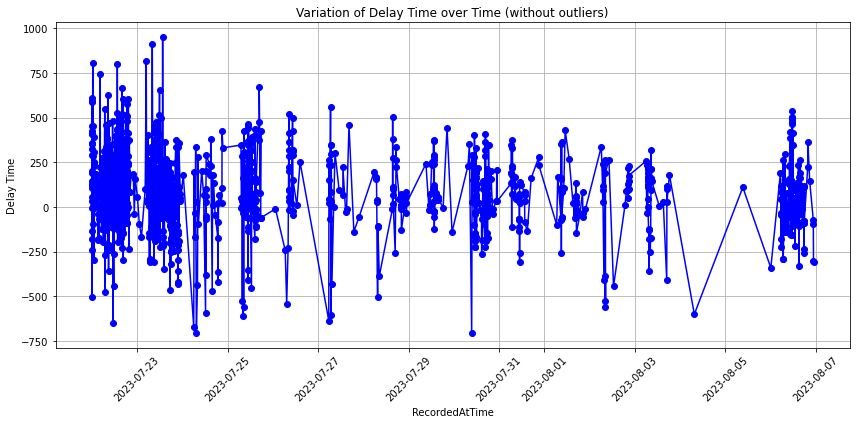

In [22]:
# show delay time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

arrivetime_df = pd.read_csv('./data/train_test_set_Nottingham.csv')
arrivetime_df['RecordedAtTime'] = pd.to_datetime(arrivetime_df['RecordedAtTime'])
arrivetime_df.sort_values(by='RecordedAtTime', inplace=True)

Q1 = arrivetime_df['delay_time'].quantile(0.25)
Q3 = arrivetime_df['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
arrivetime_df = arrivetime_df[(arrivetime_df['delay_time'] >= lower_bound) & (arrivetime_df['delay_time'] <= upper_bound)]

arrivetime_df.drop_duplicates(subset=['VehicleRef', 'real_arriveTime'], inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(arrivetime_df['RecordedAtTime'], arrivetime_df['delay_time'], marker='o', linestyle='-', color='b')
plt.xlabel('RecordedAtTime')
plt.ylabel('Delay Time')
plt.title('Variation of Delay Time over Time (without outliers)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.0 Correlation Heatmap

2338756
2338756
2205041


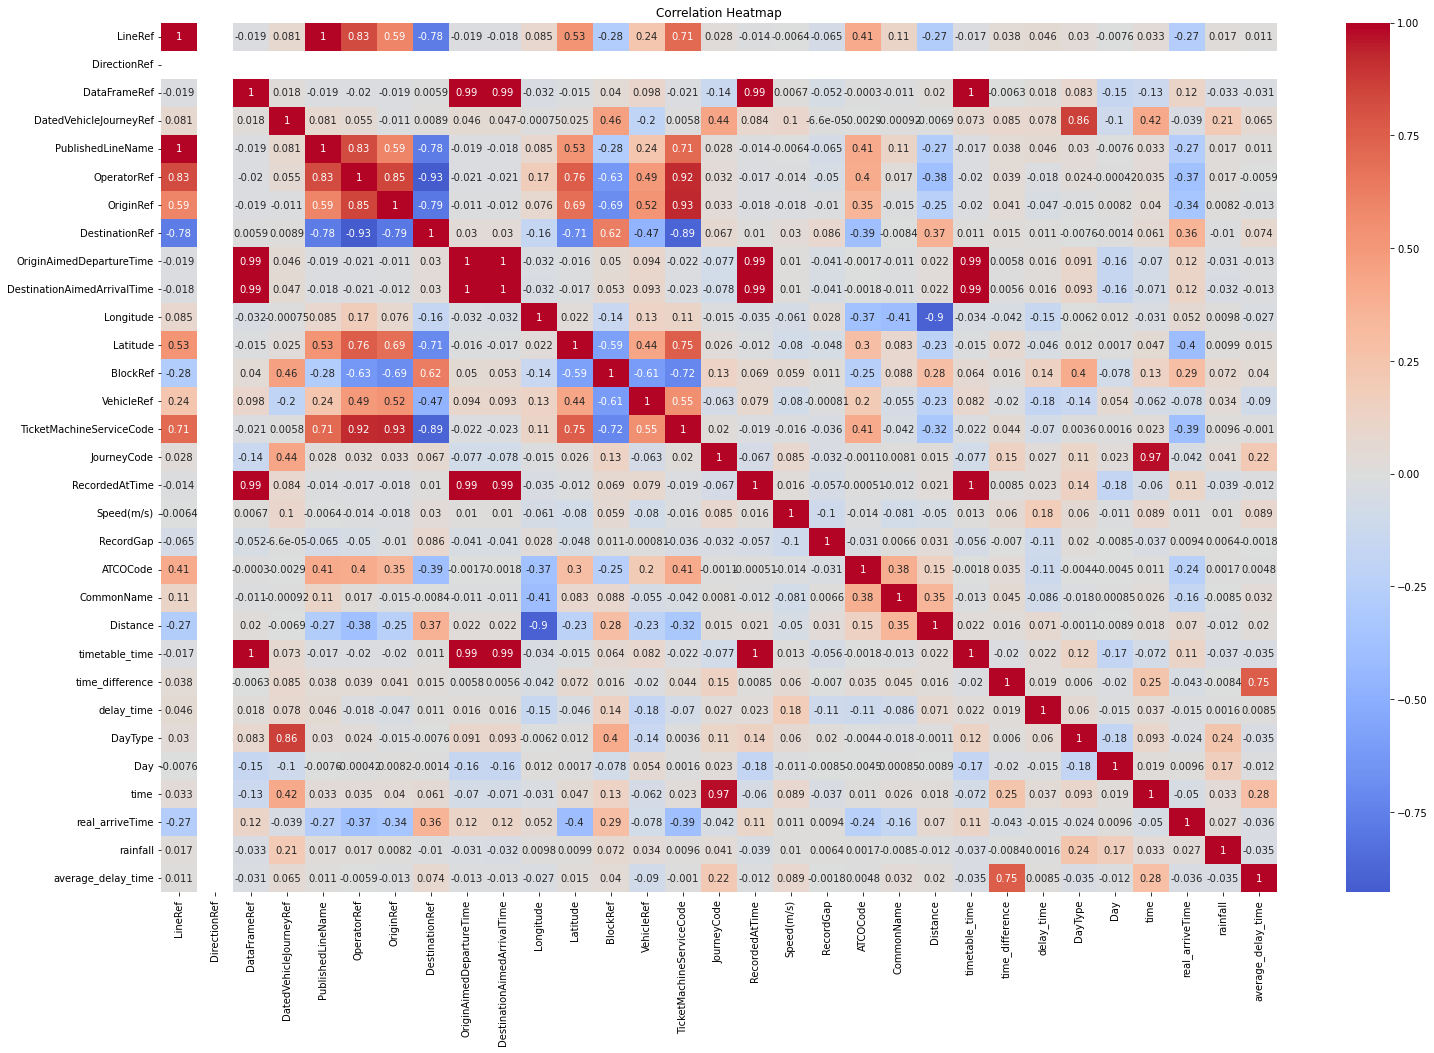

In [21]:
# encode
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
data = pd.read_csv('./data/train_test_set_nottingham.csv')
data.drop(['next_lon', 'next_la', 'OriginName', 'DestinationName', 'VehicleUniqueId'], axis=1, inplace=True)
data['RecordedAtTime_Backup'] = data['RecordedAtTime']
data['real_arriveTime_Backup'] = data['real_arriveTime']
non_numeric_columns = [
    'LineRef', 'DirectionRef', 'DataFrameRef', 'DatedVehicleJourneyRef', 'PublishedLineName',
    'OperatorRef', 'OriginRef', 'DestinationRef',
    'OriginAimedDepartureTime', 'DestinationAimedArrivalTime', 'BlockRef', 'VehicleRef',
    'TicketMachineServiceCode', 'JourneyCode', 'RecordedAtTime', 'RecordGap', 'ATCOCode', 
    'CommonName', 'timetable_time', 'DayType', 'Day', 'real_arriveTime'
]
label_encoder = LabelEncoder()
for column in non_numeric_columns:
    data[column] = label_encoder.fit_transform(data[column])
# data = pd.get_dummies(data, columns=[''])
print(len(data))

# outliners
print(len(data))
Q1 = data['delay_time'].quantile(0.25)
Q3 = data['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
data = data[(data['delay_time'] >= lower_bound) & (data['delay_time'] <= upper_bound)]
print(len(data))

# draw map
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data.corr()
plt.figure(figsize=(25, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

## 3.1 Rainfall Level vs. Delay Time

too large to visualize, just use one-week & one-line data as an example.

### 3.1.0 Original

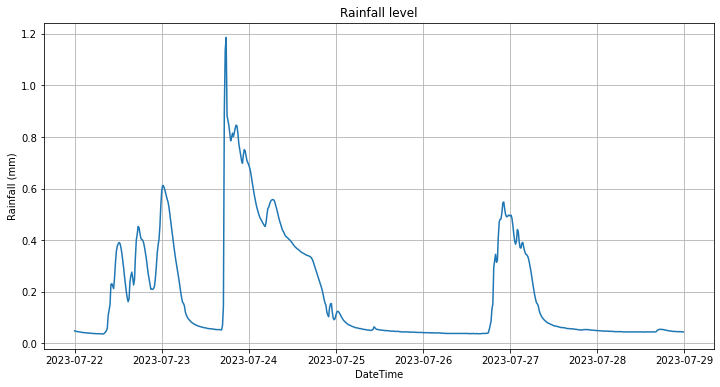

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = './data/weather_data/rainfall_data_20230806211532.csv'
df = pd.read_csv(file_path)

df['dateTime'] = pd.to_datetime(df['dateTime'])

start_time = pd.to_datetime('2023-07-22T00:00:00Z')
end_time = pd.to_datetime('2023-07-28T23:45:00Z')
filtered_df = df[(df['dateTime'] >= start_time) & (df['dateTime'] <= end_time)]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df['dateTime'], filtered_df['value'])
plt.xlabel('DateTime')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall level')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv('./data/combined_data.csv')

correlation_matrix = combined_df[['rainfall', 'new_delay_time']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Rainfall and New Delay Time')
plt.show()

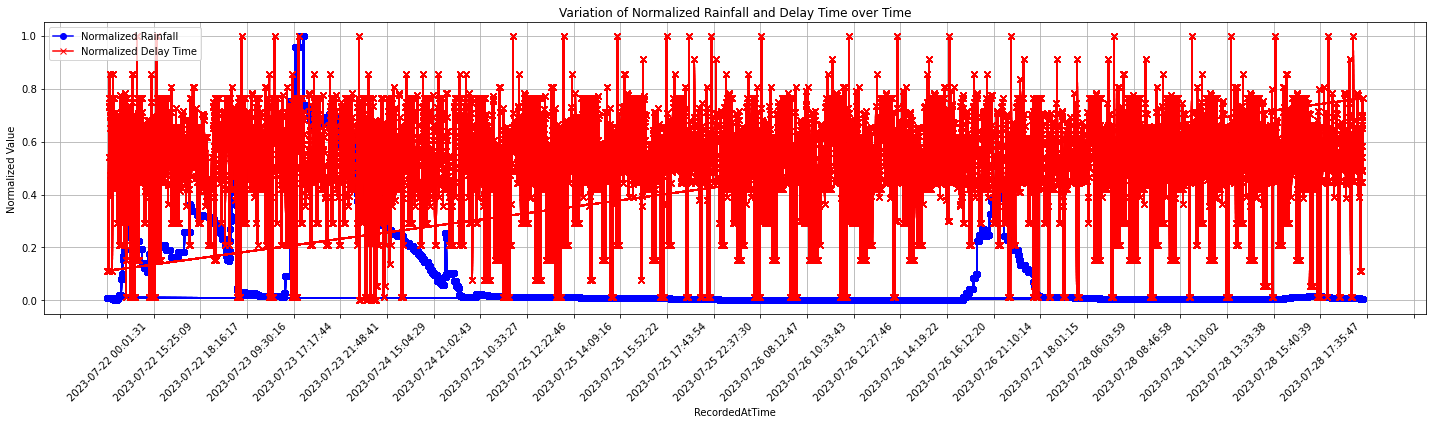

In [37]:
# visualize the rainfall ans delays

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl

# mpl.rcParams['agg.path.chunksize'] = 20000

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')
combined_df = combined_df[
                              (combined_df['PublishedLineName'] == 'two') &
                              (combined_df['RecordedAtTime'].str[:10].between('2023-07-22', '2023-07-28'))
    
                        ]

Q1 = combined_df['delay_time'].quantile(0.25)
Q3 = combined_df['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
combined_df = combined_df[(combined_df['delay_time'] >= lower_bound) & (combined_df['delay_time'] <= upper_bound)]

normalized_df = combined_df.copy()
scaler = MinMaxScaler()
normalized_df[['rainfall', 'delay_time']] = scaler.fit_transform(normalized_df[['rainfall', 'delay_time']])

plt.figure(figsize=(20, 6))
plt.plot(normalized_df['RecordedAtTime'], normalized_df['rainfall'], marker='o', linestyle='-', color='b', label='Normalized Rainfall')
plt.plot(normalized_df['RecordedAtTime'], normalized_df['delay_time'], marker='x', linestyle='-', color='r', label='Normalized Delay Time')
plt.xlabel('RecordedAtTime')
plt.ylabel('Normalized Value')
plt.title('Variation of Normalized Rainfall and Delay Time over Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


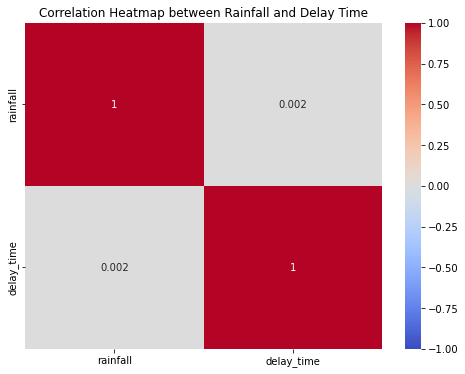

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')

correlation_matrix = combined_df[['rainfall', 'delay_time']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Rainfall and Delay Time')
plt.show()

### 3.1.1 Exclude the effect of time periods

In [ ]:
# exclude the effect of time periods using new_delay_time

combined_df = pd.read_csv('./data/train_test_set_Nottingham.csv')
combined_df['RecordedAtTime'] = pd.to_datetime(combined_df['RecordedAtTime'])
combined_df['Average_Delay_Time'] = combined_df.groupby('time')['delay_time'].transform('mean')
combined_df['New_Delay_Time'] = combined_df['delay_time'] - combined_df['Average_Delay_Time']
combined_df.to_csv('./data/train_test_set_nottingham.csv', index=False)

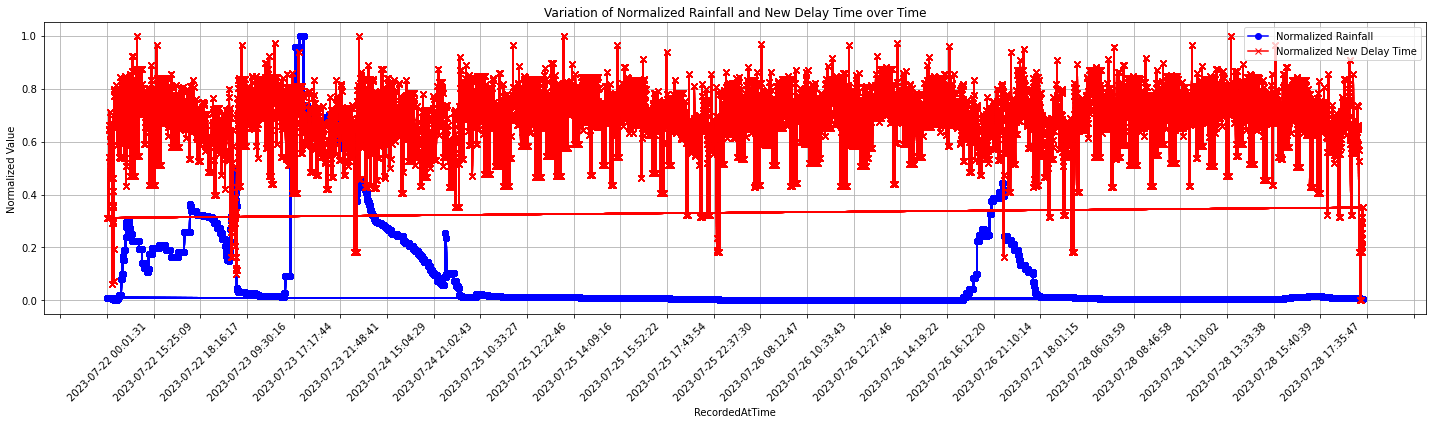

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl

# mpl.rcParams['agg.path.chunksize'] = 20000

combined_df = pd.read_csv('./data/combined_data.csv')
combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')
combined_df = combined_df[
                              (combined_df['PublishedLineName'] == 'two') &
                              (combined_df['RecordedAtTime'].str[:10].between('2023-07-22', '2023-07-28'))
    
                        ]

Q1 = combined_df['delay_time'].quantile(0.25)
Q3 = combined_df['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
combined_df = combined_df[(combined_df['delay_time'] >= lower_bound) & (combined_df['delay_time'] <= upper_bound)]

normalized_df = combined_df.copy()
scaler = MinMaxScaler()
normalized_df[['rainfall', 'New_Delay_Time']] = scaler.fit_transform(normalized_df[['rainfall', 'New_Delay_Time']])

plt.figure(figsize=(20, 6))
plt.plot(normalized_df['RecordedAtTime'], normalized_df['rainfall'], marker='o', linestyle='-', color='b', label='Normalized Rainfall')
plt.plot(normalized_df['RecordedAtTime'], normalized_df['New_Delay_Time'], marker='x', linestyle='-', color='r', label='Normalized New Delay Time')
plt.xlabel('RecordedAtTime')
plt.ylabel('Normalized Value')
plt.title('Variation of Normalized Rainfall and New Delay Time over Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


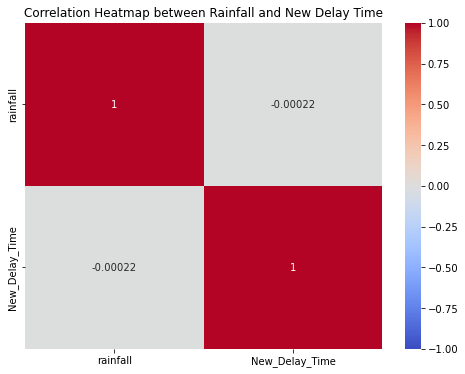

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')

correlation_matrix = combined_df[['rainfall', 'New_Delay_Time']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Rainfall and New Delay Time')
plt.show()

### 3.1.2 Exclude the effect of time lags

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

delaytime_df = pd.read_csv('./data/train_test_set_nottingham.csv')
rainfall_df = pd.read_csv('./data/weather_data/rainfall_data_20230806211532.csv')

delaytime_df['RecordedAtTime'] = pd.to_datetime(delaytime_df['RecordedAtTime']).dt.tz_localize(None)
rainfall_df['dateTime'] = pd.to_datetime(rainfall_df['dateTime']).dt.tz_localize(None)

lag = pd.Timedelta(minutes=15)
delaytime_df['RecordedAtTime_15min_before'] = delaytime_df['RecordedAtTime'] - lag

rainfall_values_15min_before = []

for _, delaytime_row in delaytime_df.iterrows():
    recorded_time = delaytime_row['RecordedAtTime_15min_before']
    time_diffs = abs(rainfall_df['dateTime'] - recorded_time)
    min_index = time_diffs.idxmin()
    rainfall_values_15min_before.append(rainfall_df.at[min_index, 'value'])

delaytime_df['rainfall_15min'] = rainfall_values_15min_before

delaytime_df.to_csv('./data/train_test_set_nottingham.csv', index=False)


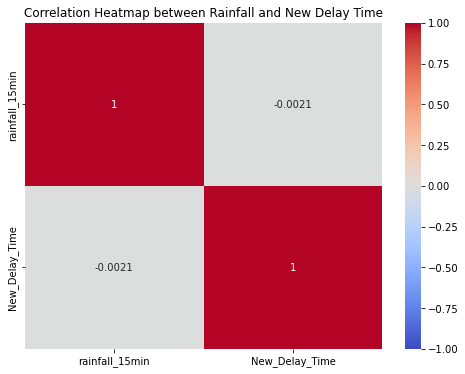

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')

correlation_matrix = combined_df[['rainfall_15min', 'New_Delay_Time']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Rainfall and New Delay Time')
plt.show()

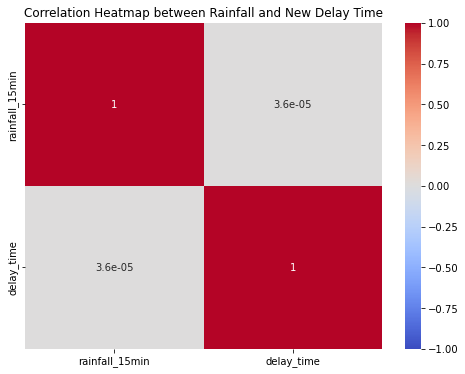

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')

correlation_matrix = combined_df[['rainfall_15min', 'delay_time']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Rainfall and New Delay Time')
plt.show()

### 3.1.2 Nonlinear patterns

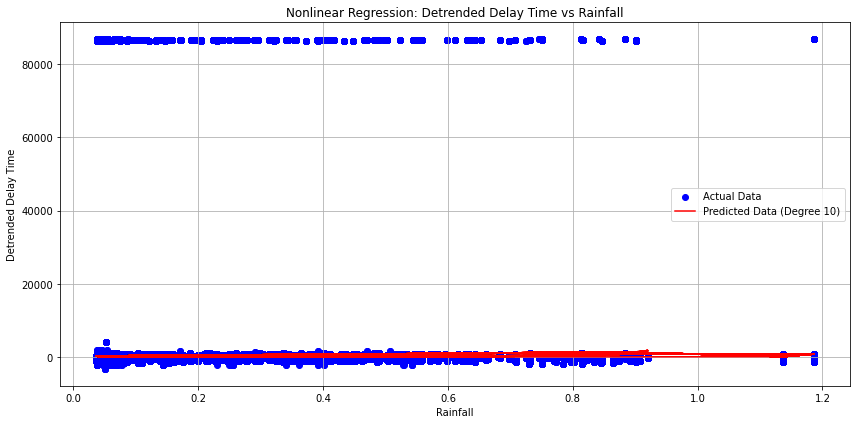

Mean Squared Error (MSE): 21956634.91
Coefficient of Determination (R²): 0.00
Mean Absolute Error (MAE): 562.07


In [63]:
# Nonlinear Regression with Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

delaytime_df = pd.read_csv('./data/train_test_set_nottingham.csv')

degree = 10
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(delaytime_df[['rainfall']])
y = delaytime_df['delay_time']

model = LinearRegression()
model.fit(X_poly, y)
y_pred = model.predict(X_poly)

plt.figure(figsize=(12, 6))
plt.scatter(delaytime_df['rainfall'], y, color='blue', label='Actual Data')
plt.plot(delaytime_df['rainfall'], y_pred, color='red', label='Predicted Data (Degree {})'.format(degree))
plt.xlabel('Rainfall')
plt.ylabel('Detrended Delay Time')
plt.title('Nonlinear Regression: Detrended Delay Time vs Rainfall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_pred = model.predict(X_poly)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


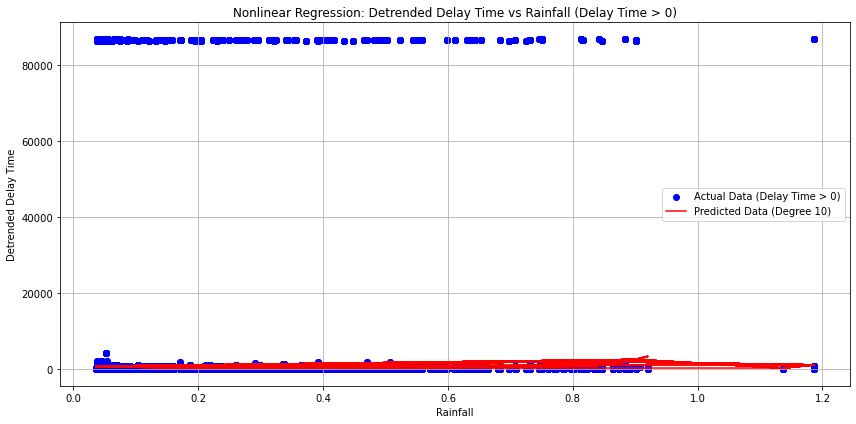

Mean Squared Error (MSE): 34439578.23
Coefficient of Determination (R²): 0.00
Mean Absolute Error (MAE): 810.30


In [64]:
# Nonlinear Regression with Polynomial Features and Feature Scaling
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

delaytime_df = pd.read_csv('./data/train_test_set_nottingham.csv')

degree = 10
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(delaytime_df[['rainfall']])
y = delaytime_df['delay_time']

# Filter out rows with delay time <= 0
positive_delay_indices = y > 0
X_poly_positive = X_poly[positive_delay_indices]
y_positive = y[positive_delay_indices]

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly_positive)

model = LinearRegression()
model.fit(X_scaled, y_positive)
y_pred = model.predict(X_scaled)

plt.figure(figsize=(12, 6))
plt.scatter(delaytime_df.loc[positive_delay_indices, 'rainfall'], y_positive, color='blue', label='Actual Data (Delay Time > 0)')
plt.plot(delaytime_df.loc[positive_delay_indices, 'rainfall'], y_pred, color='red', label='Predicted Data (Degree {})'.format(degree))
plt.xlabel('Rainfall')
plt.ylabel('Detrended Delay Time')
plt.title('Nonlinear Regression: Detrended Delay Time vs Rainfall (Delay Time > 0)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_positive, y_pred)
r2 = r2_score(y_positive, y_pred)
mae = mean_absolute_error(y_positive, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [ ]:
# Nonlinear Regression with Support Vector Regression (SVR)
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
delaytime_df = pd.read_csv('./data/train_test_set_nottingham.csv')

degree = 10
X = delaytime_df[['rainfall']]
y = delaytime_df['delay_time']

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

svr_model = SVR(kernel='poly', degree=degree)
svr_model.fit(X_poly, y)

y_pred = svr_model.predict(X_poly)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

plt.figure(figsize=(12, 6))
plt.scatter(delaytime_df['rainfall'], y, color='blue', label='Actual Data')
plt.plot(delaytime_df['rainfall'], y_pred, color='red', label='SVR Prediction (Degree {})'.format(degree))
plt.xlabel('Rainfall')
plt.ylabel('Detrended Delay Time')
plt.title('Nonlinear Regression: Detrended Delay Time vs Rainfall (SVR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')

X = combined_df[['rainfall']]
y = combined_df['delay_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train[['rainfall']])
X_test['cluster'] = kmeans.predict(X_test[['rainfall']])

model = LinearRegression()
model.fit(X_train[['cluster']], y_train)
y_pred = model.predict(X_test[['cluster']])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_train['rainfall'], y_train, c=X_train['cluster'], cmap='rainbow')
plt.xlabel('Rainfall')
plt.ylabel('Delay Time')
plt.title('Clustered Data')
plt.colorbar(label='Cluster')
plt.show()


### 3.1.3 predict delay time from rainfall level

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')
X = combined_df[['rainfall']]
y = combined_df['delay_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
svr_model = SVR(kernel='rbf', C=1.0)
svr_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
svr_pred = svr_model.predict(X_test)
ensemble_pred = (gb_pred + svr_pred) / 2
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"Ensemble Mean Squared Error (MSE): {ensemble_mse:.2f}")
print(f"Ensemble Coefficient of Determination (R²): {ensemble_r2:.2f}")


/Users/feiwenli/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

combined_df = pd.read_csv('./data/train_test_set_nottingham.csv')
X = combined_df[['rainfall']]
y = combined_df['delay_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,   
    min_samples_split=6, 
    min_samples_leaf=1,   
    max_features='auto', 
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red', line_kws={'color': 'green'})
plt.xlabel('Actual Delay Time')
plt.ylabel('Predicted Delay Time')
plt.title('Actual vs Predicted Delay Time using Random Forest Regression')
plt.show()

## 3.2 Time Periods vs. Delay Time

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1485831348.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['RecordedAtTime'].dt.hour
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1485831348.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average_Delay_Time'] = average_delay_per_hour


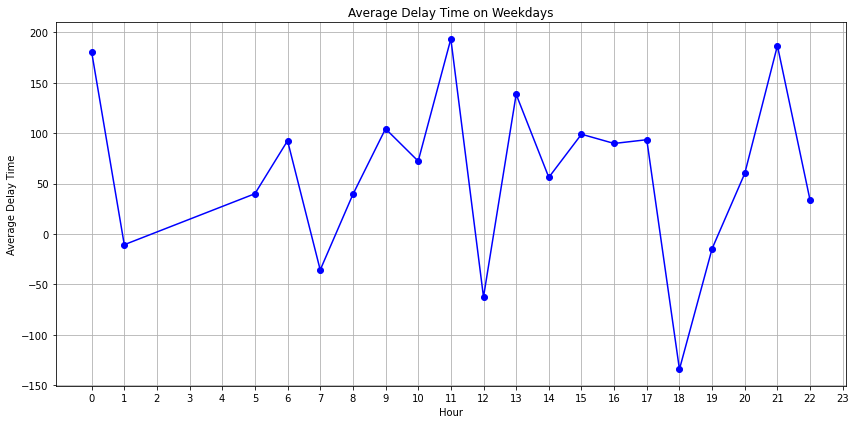

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1485831348.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['RecordedAtTime'].dt.hour
/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1485831348.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average_Delay_Time'] = average_delay_per_hour


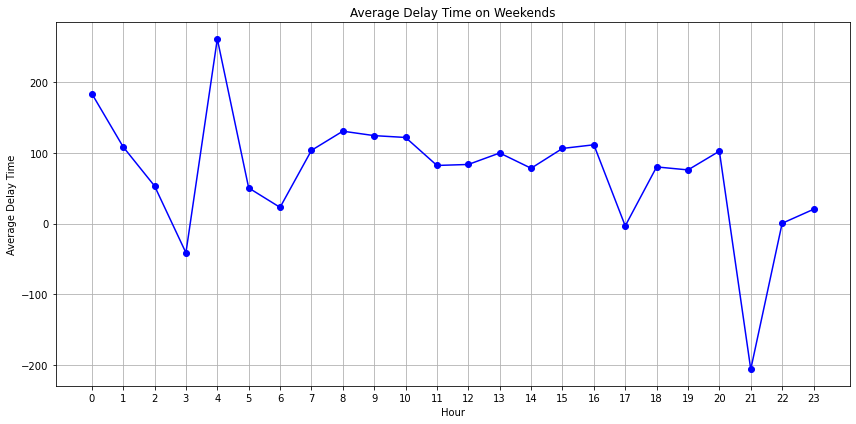

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_df = pd.read_csv('./data/train_test_set_Nottingham.csv')

combined_df['RecordedAtTime'] = pd.to_datetime(combined_df['RecordedAtTime'])

combined_df.drop_duplicates(subset=['VehicleRef', 'real_arriveTime'], inplace=True)

Q1 = combined_df['delay_time'].quantile(0.25)
Q3 = combined_df['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
combined_df = combined_df[(combined_df['delay_time'] >= lower_bound) & (combined_df['delay_time'] <= upper_bound)]

combined_df['Hour'] = combined_df['RecordedAtTime'].dt.hour

weekday_df = combined_df[combined_df['DayType'] == 'weekday']
weekend_df = combined_df[combined_df['DayType'] == 'weekend']

def plot_average_delay(df, title):
    df['Hour'] = df['RecordedAtTime'].dt.hour
    average_delay_per_hour = df.groupby('Hour')['delay_time'].mean()
    df['Average_Delay_Time'] = average_delay_per_hour

    plt.figure(figsize=(12, 6))

    plt.plot(average_delay_per_hour.index, average_delay_per_hour.values, marker='o', linestyle='-', color='b')

    plt.xlabel('Hour')
    plt.ylabel('Average Delay Time')
    plt.title(title)
    plt.xticks(range(24)) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_average_delay(weekday_df, 'Average Delay Time on Weekdays')
plot_average_delay(weekend_df, 'Average Delay Time on Weekends')\

## 3.3 Stop Location vs. Delay Time

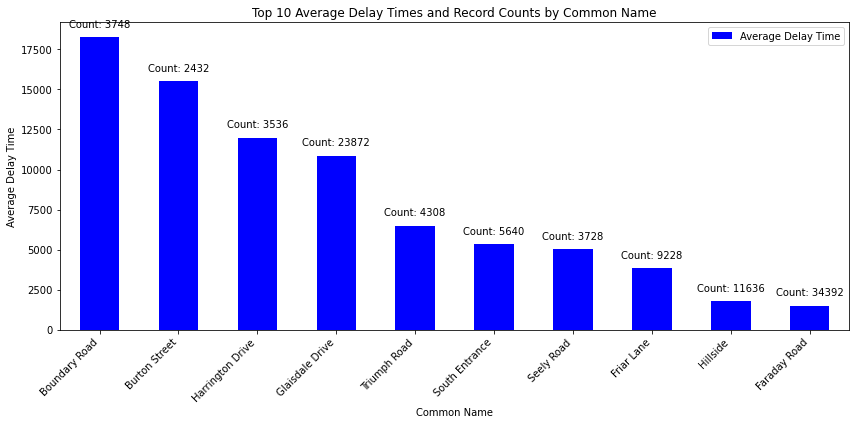

In [27]:
# Top 10 Average Delay Times by Common Name

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./data/train_test_set_nottingham.csv")
grouped_data = data.groupby('CommonName')['delay_time'].agg(['mean', 'count'])
grouped_data = grouped_data[grouped_data['count'] >= 1000]
top_10_common_names = grouped_data.sort_values(by='mean', ascending=False).head(10)
plt.figure(figsize=(12, 6))
ax = top_10_common_names['mean'].plot(kind='bar', color='blue', label='Average Delay Time')
ax.set_ylabel("Average Delay Time")
ax.set_xlabel("Common Name")
ax.set_xticklabels(top_10_common_names.index, rotation=45, ha='right')
ax.legend()
for i, count in enumerate(top_10_common_names['count']):
    ax.annotate(f"Count: {count}", (i, top_10_common_names['mean'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Top 10 Average Delay Times and Record Counts by Common Name")
plt.tight_layout()
plt.show()


In [28]:
# draw a map to visualize the stops with delaytime (colour means delay time, size means amount of records)

import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from matplotlib.colors import LinearSegmentedColormap

data = pd.read_csv("./data/train_test_set_nottingham.csv")

grouped_data = data.groupby(['CommonName', 'next_lon', 'next_la'])['delay_time'].agg(['mean', 'count']).reset_index()
grouped_data = grouped_data[(grouped_data['count'] >= 100) & (grouped_data['count'] <= 40000)]
common_names = grouped_data.sort_values(by='mean', ascending=False)

world = gpd.datasets.get_path('naturalearth_lowres')
map_background = gpd.read_file(world)
m = folium.Map(location=[53.00, -1.20], zoom_start=10)

max_delay = common_names['mean'].max()
min_delay = common_names['mean'].min()
colors = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'red'])

for _, row in common_names.iterrows():
    normalized_delay = (row['mean'] - min_delay) / (max_delay - min_delay)
    color = colors(normalized_delay)
    color_hex = "#{:02X}{:02X}{:02X}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    
    radius = row['count'] / 1000 + 5
    
    folium.CircleMarker(
        location=[row['next_la'], row['next_lon']],
        radius=radius,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        popup=f"{row['CommonName']}<br>Avg Delay: {row['mean']:.2f}<br>Record Count: {row['count']}",
    ).add_to(m)

m.save("delay_map_byStop.html")

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/2308223239.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.datasets.get_path('naturalearth_lowres')


/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1012437428.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['RecordedAtTime'].dt.hour


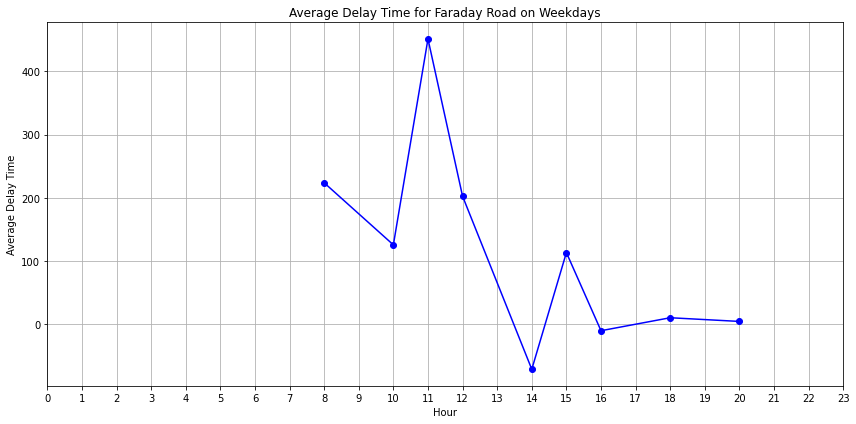

/var/folders/w6/h9slnslx2bz1n03pgkfrpd700000gn/T/ipykernel_13303/1012437428.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['RecordedAtTime'].dt.hour


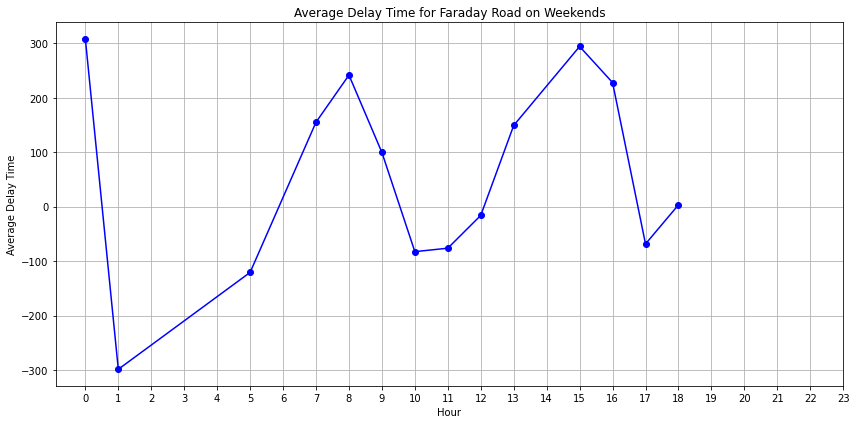

In [31]:
# 'Faraday Road' is between student accomodation and jubilee campus. Check the effect of school time.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_df = pd.read_csv('./data/train_test_set_Nottingham.csv')
combined_df = combined_df[
                              (combined_df['CommonName'] == 'Faraday Road')
                        ]

combined_df['RecordedAtTime'] = pd.to_datetime(combined_df['RecordedAtTime'])

combined_df.drop_duplicates(subset=['VehicleRef', 'real_arriveTime'], inplace=True)

Q1 = combined_df['delay_time'].quantile(0.25)
Q3 = combined_df['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
combined_df = combined_df[(combined_df['delay_time'] >= lower_bound) & (combined_df['delay_time'] <= upper_bound)]
combined_df['Hour'] = combined_df['RecordedAtTime'].dt.hour

weekday_df = combined_df[combined_df['DayType'] == 'weekday']
weekend_df = combined_df[combined_df['DayType'] == 'weekend']

def plot_average_delay(df, title):
    df['Hour'] = df['RecordedAtTime'].dt.hour
    average_delay_per_hour = df.groupby('Hour')['delay_time'].mean()

    plt.figure(figsize=(12, 6))

    plt.plot(average_delay_per_hour.index, average_delay_per_hour.values, marker='o', linestyle='-', color='b')

    plt.xlabel('Hour')
    plt.ylabel('Average Delay Time')
    plt.title(title)
    plt.xticks(range(24)) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_average_delay(weekday_df, 'Average Delay Time for Faraday Road on Weekdays')
plot_average_delay(weekend_df, 'Average Delay Time for Faraday Road on Weekends')


## 3.4 Routes and Directions vs. Delay Time

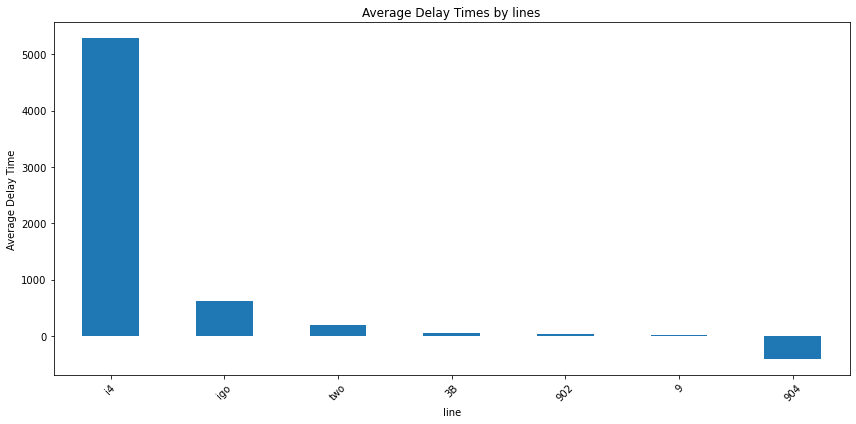

In [29]:
# all use 'inbound' as direction

import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("./data/train_test_set_nottingham.csv")
average_delay_by_common_name = data.groupby('LineRef')['delay_time'].mean()
top_10_common_names = average_delay_by_common_name.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_10_common_names.plot(kind='bar')
plt.title("Average Delay Times by lines")
plt.xlabel("line")
plt.ylabel("Average Delay Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Prediction Model

## 4.1 pre-processing

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

data = pd.read_csv('./data/train_test_set_nottingham.csv')
data.drop(['next_lon', 'next_la', 'OriginName', 'DestinationName', 'VehicleUniqueId'], axis=1, inplace=True)

data['RecordedAtTime_Backup'] = data['RecordedAtTime']
data['real_arriveTime_Backup'] = data['real_arriveTime']

non_numeric_columns = [
    'LineRef', 'DirectionRef', 'DataFrameRef', 'DatedVehicleJourneyRef', 'PublishedLineName',
    'OperatorRef', 'OriginRef', 'DestinationRef',
    'OriginAimedDepartureTime', 'DestinationAimedArrivalTime', 'BlockRef', 'VehicleRef',
    'TicketMachineServiceCode', 'JourneyCode', 'RecordedAtTime', 'RecordGap', 'ATCOCode', 
    'CommonName', 'timetable_time', 'DayType', 'Day', 'real_arriveTime'
]

label_encoder = LabelEncoder()
for column in non_numeric_columns:
    data[column] = label_encoder.fit_transform(data[column])
# data = pd.get_dummies(data, columns=[''])

print(len(data))

2338756


In [5]:
print(data.isnull().sum())
# data = data.fillna(data.mode().iloc[0])
# data['VehicleUniqueId'] = data['VehicleUniqueId'].fillna(data['VehicleUniqueId'].median())

LineRef                        0
DirectionRef                   0
DataFrameRef                   0
DatedVehicleJourneyRef         0
PublishedLineName              0
OperatorRef                    0
OriginRef                      0
DestinationRef                 0
OriginAimedDepartureTime       0
DestinationAimedArrivalTime    0
Longitude                      0
Latitude                       0
BlockRef                       0
VehicleRef                     0
TicketMachineServiceCode       0
JourneyCode                    0
RecordedAtTime                 0
Speed(m/s)                     0
RecordGap                      0
ATCOCode                       0
CommonName                     0
Distance                       0
timetable_time                 0
time_difference                0
delay_time                     0
DayType                        0
Day                            0
time                           0
real_arriveTime                0
rainfall                       0
average_de

In [6]:
print(len(data))

Q1 = data['delay_time'].quantile(0.25)
Q3 = data['delay_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
data = data[(data['delay_time'] >= lower_bound) & (data['delay_time'] <= upper_bound)]

print(len(data))

2338756
2205041


## 4.2 columns check

In [7]:
print(data.columns)

Index(['LineRef', 'DirectionRef', 'DataFrameRef', 'DatedVehicleJourneyRef',
       'PublishedLineName', 'OperatorRef', 'OriginRef', 'DestinationRef',
       'OriginAimedDepartureTime', 'DestinationAimedArrivalTime', 'Longitude',
       'Latitude', 'BlockRef', 'VehicleRef', 'TicketMachineServiceCode',
       'JourneyCode', 'RecordedAtTime', 'Speed(m/s)', 'RecordGap', 'ATCOCode',
       'CommonName', 'Distance', 'timetable_time', 'time_difference',
       'delay_time', 'DayType', 'Day', 'time', 'real_arriveTime', 'rainfall',
       'average_delay_time', 'Average_Delay_Time', 'New_Delay_Time',
       'RecordedAtTime_15min_before', 'rainfall_15min',
       'RecordedAtTime_Backup', 'real_arriveTime_Backup'],
      dtype='object')


In [8]:
print(len(data))
condition = ((data['time'] >= 0) & (data['time'] <= 5)) | ((data['time'] >= 9) & (data['time'] <= 12))
data = data[~condition]
print(len(data))

2205041
1516996


## 4.3 model without considering external factors

In [15]:
columns_to_remove = ['Speed(m/s)', 'RecordGap', 'ATCOCode',
       'CommonName', 'Distance', 'timetable_time',
       'time_difference', 'DayType', 'Day', 'time',
       'real_arriveTime', 'rainfall', 'average_delay_time',
       'Average_Delay_Time', 'New_Delay_Time', 'RecordedAtTime_15min_before', 'rainfall_15min',
       'real_arriveTime_Backup']

data_original = data.drop(columns=columns_to_remove)

Random Forest Regressor:
Mean Squared Error (MSE): 3306.47
Mean Absolute Error (MAE): 18.99
R-squared (R2): 0.94


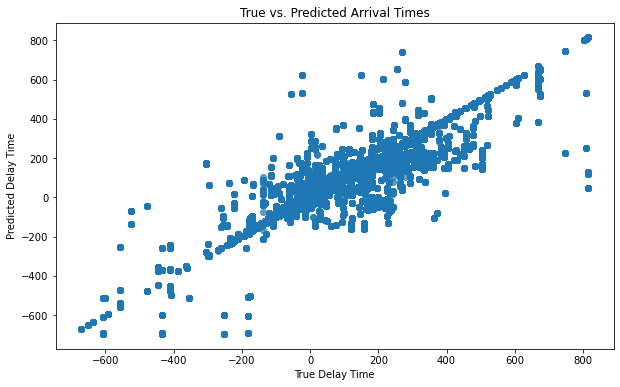

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from sklearn.metrics import r2_score

# data_original['real_arriveTime_Backup'] = pd.to_datetime(data_original['real_arriveTime_Backup']).astype(int)

import matplotlib.pyplot as plt

train_data = data_original[data_original['RecordedAtTime_Backup'].between('2023-07-21', '2023-08-01')]
test_data = data_original[data_original['RecordedAtTime_Backup'].between('2023-08-02', '2023-08-06')]

train_data = train_data.drop(['RecordedAtTime_Backup'], axis=1)
test_data = test_data.drop(['RecordedAtTime_Backup'], axis=1)

correlation_matrix = train_data.corr()

feature_weights = abs(correlation_matrix['delay_time']).sort_values(ascending=False)
total_weight = feature_weights.sum()
feature_weights_normalized = feature_weights / total_weight
feature_weights_dict = {feature: weight for feature, weight in zip(feature_weights.index, feature_weights_normalized)}


X_train = train_data.drop(['delay_time'], axis=1)
y_train = train_data['delay_time']
X_test = test_data.drop(['delay_time'], axis=1)
y_test = test_data['delay_time']
rf_model_1 = RandomForestRegressor(random_state=42)
rf_model_1.fit(X_train, y_train)
y_pred = rf_model_1.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title("True vs. Predicted Arrival Times")
plt.xlabel("True Delay Time")
plt.ylabel("Predicted Delay Time")
plt.show()

## 4.4 model considering external factors

In [9]:
columns_to_remove = [
       'RecordedAtTime_15min_before',
       'real_arriveTime', 
       'real_arriveTime_Backup']

data_effect = data.drop(columns=columns_to_remove)

Random Forest Regressor:
Mean Squared Error (MSE): 174.17
Mean Absolute Error (MAE): 3.69
R-squared (R2): 1.00


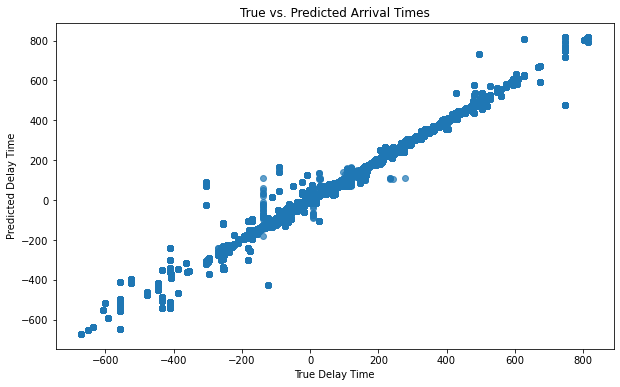

In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# data_original['real_arriveTime_Backup'] = pd.to_datetime(data_original['real_arriveTime_Backup']).astype(int)

train_data = data_effect[data_effect['RecordedAtTime_Backup'].between('2023-07-21', '2023-08-01')]
test_data = data_effect[data_effect['RecordedAtTime_Backup'].between('2023-08-02', '2023-08-06')]

train_data = train_data.drop(['RecordedAtTime_Backup'], axis=1)
test_data = test_data.drop(['RecordedAtTime_Backup'], axis=1)

correlation_matrix = train_data.corr()

# feature_weights = abs(correlation_matrix['delay_time']).sort_values(ascending=False)
# total_weight = feature_weights.sum()
# feature_weights_normalized = feature_weights / total_weight
# feature_weights_dict = {feature: weight for feature, weight in zip(feature_weights.index, feature_weights_normalized)}


X_train = train_data.drop(['delay_time'], axis=1)
y_train = train_data['delay_time']
X_test = test_data.drop(['delay_time'], axis=1)
y_test = test_data['delay_time']
rf_model_2 = RandomForestRegressor(random_state=42)
rf_model_2.fit(X_train, y_train)
y_pred = rf_model_2.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title("True vs. Predicted Arrival Times")
plt.xlabel("True Delay Time")
plt.ylabel("Predicted Delay Time")
plt.show()

## 4.5 model just considering rainfall

In [26]:
columns_to_remove = ['Speed(m/s)', 'RecordGap', 'ATCOCode',
       'CommonName', 'Distance', 'timetable_time',
       'time_difference', 'DayType', 'Day', 'time',
       'real_arriveTime', 'average_delay_time',
       'Average_Delay_Time', 'New_Delay_Time', 'RecordedAtTime_15min_before', 
       'real_arriveTime_Backup']


data_rainfall = data.drop(columns=columns_to_remove)

Random Forest Regressor:
Mean Squared Error (MSE): 3385.17
Mean Absolute Error (MAE): 19.33
R-squared (R2): 0.94


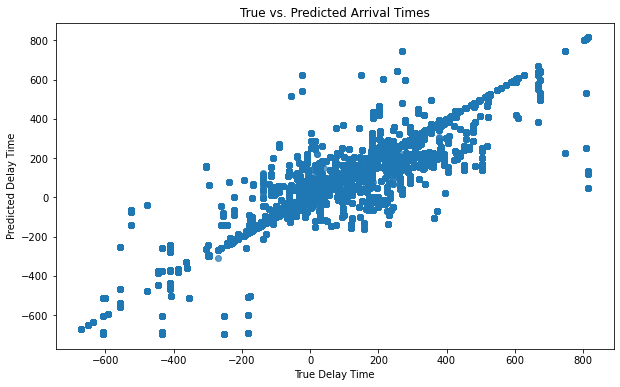

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

# data_original['real_arriveTime_Backup'] = pd.to_datetime(data_original['real_arriveTime_Backup']).astype(int)

train_data = data_rainfall[data_rainfall['RecordedAtTime_Backup'].between('2023-07-21', '2023-08-01')]
test_data = data_rainfall[data_rainfall['RecordedAtTime_Backup'].between('2023-08-02', '2023-08-06')]

train_data = train_data.drop(['RecordedAtTime_Backup'], axis=1)
test_data = test_data.drop(['RecordedAtTime_Backup'], axis=1)

correlation_matrix = train_data.corr()

# feature_weights = abs(correlation_matrix['delay_time']).sort_values(ascending=False)
# total_weight = feature_weights.sum()
# feature_weights_normalized = feature_weights / total_weight
# feature_weights_dict = {feature: weight for feature, weight in zip(feature_weights.index, feature_weights_normalized)}


X_train = train_data.drop(['delay_time'], axis=1)
y_train = train_data['delay_time']
X_test = test_data.drop(['delay_time'], axis=1)
y_test = test_data['delay_time']
rf_model_3 = RandomForestRegressor(random_state=42)
rf_model_3.fit(X_train, y_train)
y_pred = rf_model_3.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title("True vs. Predicted Arrival Times")
plt.xlabel("True Delay Time")
plt.ylabel("Predicted Delay Time")
plt.show()

# 5. Extension --- User's real-time information check system

Input: station name -----> Output: the information of the next coming bus & predicted arrive time

In [17]:
import pandas as pd
import tkinter as tk
from tkinter import messagebox
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta

def preprocess_data(data):
    data.drop(['next_lon', 'next_la', 'OriginName', 'DestinationName', 'VehicleUniqueId'], axis=1, inplace=True)
    
    data['RecordedAtTime_Backup'] = data['RecordedAtTime']
    data['real_arriveTime_Backup'] = data['real_arriveTime']

    non_numeric_columns = [
        'LineRef', 'DirectionRef', 'DataFrameRef', 'DatedVehicleJourneyRef', 'PublishedLineName',
        'OperatorRef', 'OriginRef', 'DestinationRef',
        'OriginAimedDepartureTime', 'DestinationAimedArrivalTime', 'BlockRef', 'VehicleRef',
        'TicketMachineServiceCode', 'JourneyCode', 'RecordedAtTime', 'RecordGap', 'ATCOCode', 
        'CommonName', 'timetable_time', 'DayType', 'Day', 'real_arriveTime'
    ]

    label_encoder = LabelEncoder()
    for column in non_numeric_columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    Q1 = data['delay_time'].quantile(0.25)
    Q3 = data['delay_time'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    data = data[(data['delay_time'] >= lower_bound) & (data['delay_time'] <= upper_bound)]

    condition = ((data['time'] >= 0) & (data['time'] <= 5)) | ((data['time'] >= 9) & (data['time'] <= 12))
    data = data[~condition]
    
    return data

def handle_button_click():
    try:
        station_name = text_input.get()
        
        data = pd.read_csv('./data/train_test_set_Nottingham.csv')
        filtered_data = data[data['CommonName'].str.contains(station_name, case=False)]
        filtered_data = filtered_data.sort_values(by='RecordedAtTime', ascending=False).iloc[0].to_frame().T
        print(filtered_data)
        
        timetable_time = filtered_data['timetable_time'].iloc[0]
        common_name = filtered_data['CommonName'].iloc[0]
        line_ref = filtered_data['LineRef'].iloc[0]
        
        filtered_data = preprocess_data(filtered_data)
        
        recorded_time_backup = filtered_data['RecordedAtTime_Backup'].iloc[0]
        print(type(recorded_time_backup))

#         columns_to_remove = ['real_arriveTime_Backup', 'RecordedAtTime_Backup', 'RecordedAtTime_15min_before']
        columns_to_remove = [
       'RecordedAtTime_15min_before',
       'RecordedAtTime_Backup',
       'real_arriveTime', 
       'real_arriveTime_Backup']
        X_test = filtered_data.drop(columns=columns_to_remove)
        X_test = X_test.drop(['delay_time'], axis=1)
        
        y_pred = rf_model_2.predict(X_test)
        
        
        result_window = tk.Tk()
        result_window.title("Predicted Delay Results")

        text_widget = tk.Text(result_window)
        text_widget.pack()

        real_arriveTime_backup = pd.to_datetime(recorded_time_backup)
        predicted_arrive_time = real_arriveTime_backup + timedelta(seconds=y_pred[0])
        text_widget.insert(tk.END, f"Station: {common_name}\n")
        text_widget.insert(tk.END, f"Line: {line_ref}\n")
        text_widget.insert(tk.END, f"Aimed Arrive Time: {timetable_time}\n")
        text_widget.insert(tk.END, f"Predicted Arrive Time: {predicted_arrive_time}\n\n")
        
        print(f"Station: {common_name}\n")
        print(f"Line: {line_ref}\n")
        print(f"Predicted Arrive Time: {predicted_arrive_time}\n\n")

        result_window.mainloop()

    except Exception as e:
        error_message = f"An error occurred: {e}"
        messagebox.showerror("Error", error_message)

root = tk.Tk()
root.title("Check Bus")
text_label = tk.Label(root, text="Enter station name:")
text_label.pack()
text_input = tk.Entry(root)
text_input.pack()
button = tk.Button(root, text="Find Bus", command=handle_button_click)
button.pack()
root.mainloop()

        LineRef DirectionRef DataFrameRef DatedVehicleJourneyRef  \
2269438     two      inbound   2023-08-06                 712345   

        PublishedLineName OperatorRef OriginRef  \
2269438               two        TBTN  3390VB05   

                               OriginName DestinationRef  \
2269438  Nottingham__Victoria_Bus_Station   1000DCSB5568   

                  DestinationName  ...  DayType     Day time  \
2269438  Cotmanhay__Swanwick_Road  ...  weekend  Sunday   22   

                       real_arriveTime rainfall average_delay_time  \
2269438  2023-08-02 21:53:42.000000000    0.042        1176.242232   

        Average_Delay_Time New_Delay_Time RecordedAtTime_15min_before  \
2269438         537.403178    -336.403178         2023-08-06 22:33:57   

        rainfall_15min  
2269438          0.042  

[1 rows x 40 columns]
<class 'str'>
Station: Upper Parliament Street

Line: two

Predicted Arrive Time: 2023-08-06 22:52:09.243170


